In [2]:
import netCDF4 as nc
from netCDF4 import Dataset

import numpy as np
from scipy.ndimage import convolve

import matplotlib.pyplot as plt

In [3]:
def movmean(arr, window): 
    kernel = np.ones((window[0], window[1]))/(window[0]*window[1])
    conv = convolve(arr, kernel, mode='reflect')
    return conv

In [4]:
def destripe(bt, row_w = 2, Nj = 2):

# simple destriping function based on windowed median filters
# special attention given to areas with high gradients to preserve the original resolution

# use: bt_destriped = desripe(bt) 
    
    N, K = bt.shape
    W = np.zeros((N, K, Nj))
    for j in range(Nj):
        col_w = 1 + j
        for n in range(row_w, N - row_w):
            for k in range(K):
                start_col = k - col_w
                end_col = k + col_w
                if k < col_w:
                    cols = np.arange(0, 1 + 2 * col_w)
                elif k > K - col_w - 1:
                    cols = np.arange(K - 2 * col_w - 1, K)
                else:
                    cols = np.arange(start_col, end_col + 1)
                win = bt[n - row_w:n + row_w + 1, cols]
                mw = np.median(win, axis=0)
                W[n, k, j] = np.median(win[row_w, :] - mw)
    
    W = np.nanmean(W, axis=2)
    bt_w = bt - W

    dWdY, dWdX = np.gradient(bt_w)

    data = dWdY.ravel()
    q = np.quantile(data, [0.25, 0.75])
    IQR = q[1] - q[0]
    ind = np.where((data > q[0] - 1.5 * IQR) & (data < q[1] + 1.5 * IQR))[0]
    Sbar = np.std(data[ind])
    pos = np.where(np.abs(dWdY / Sbar) > 3.5)
    Mask = np.zeros((N, K))
    Mask[pos] = 1

    MA = movmean(Mask, [3, 3])
    MA[np.where(MA > 0)] = 1
    MW = movmean(MA, [3, 3])

    bt_hat = np.multiply(MW, bt) + np.multiply((1 - MW),bt_w)
    
    return bt_hat

In [5]:
name='TMS02.1B-TBR.V01-00.NRT.ST20250501-000321.ET20250501-001705.CT20250501-003117.nc';

# read BT's
nc_file = Dataset(name, 'r')
brightness_temp = nc_file.variables['brightness_temperature'][:]

K, N, Nbands = brightness_temp.shape

# reshape
bt_all = brightness_temp.transpose(1, 0, 2).reshape(-1, K, Nbands)

In [6]:
bt_destriped = np.full((N, K, Nbands), np.nan)

for band in range(Nbands):
    bt_destriped[:, :, band] = destripe(bt_all[:, :, band])

C:\Users\Irina\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\Irina\anaconda3\lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


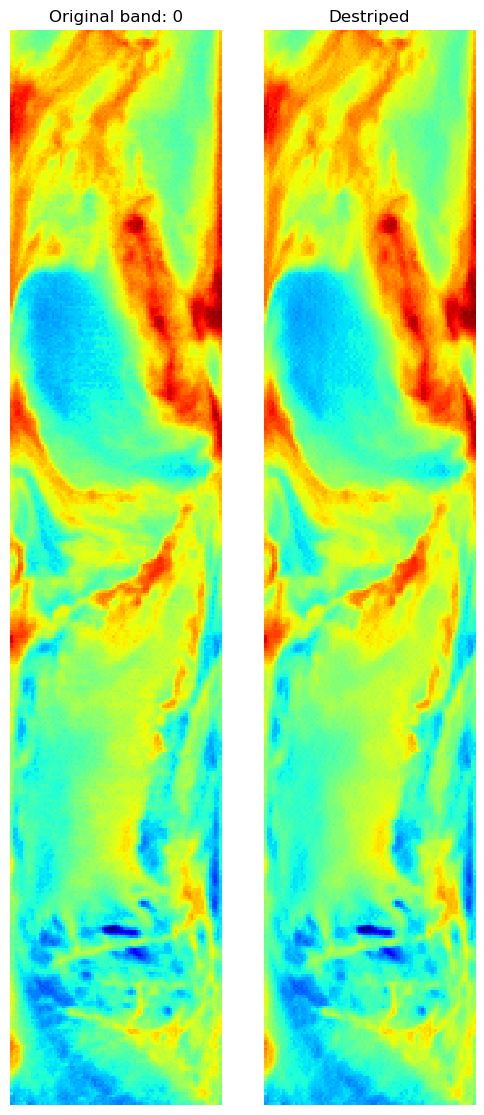

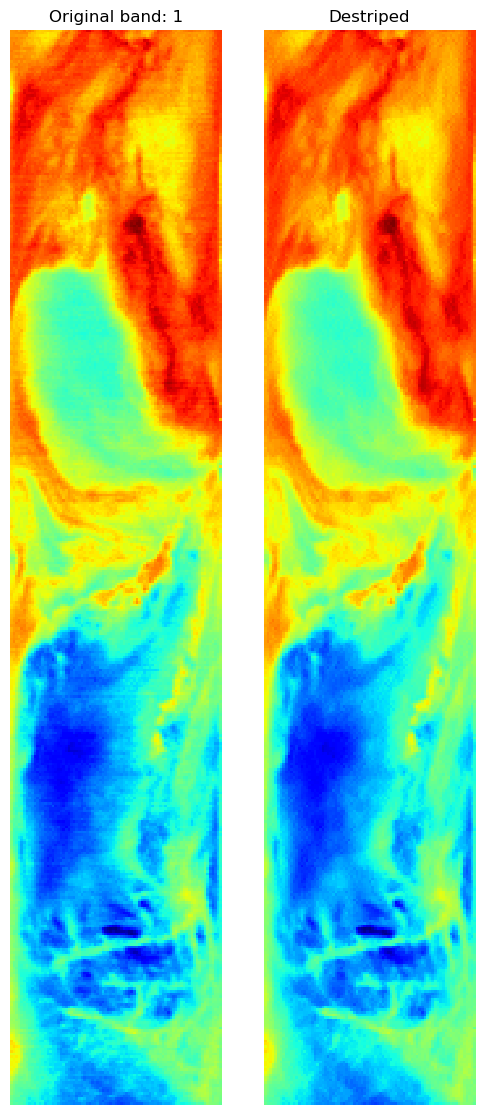

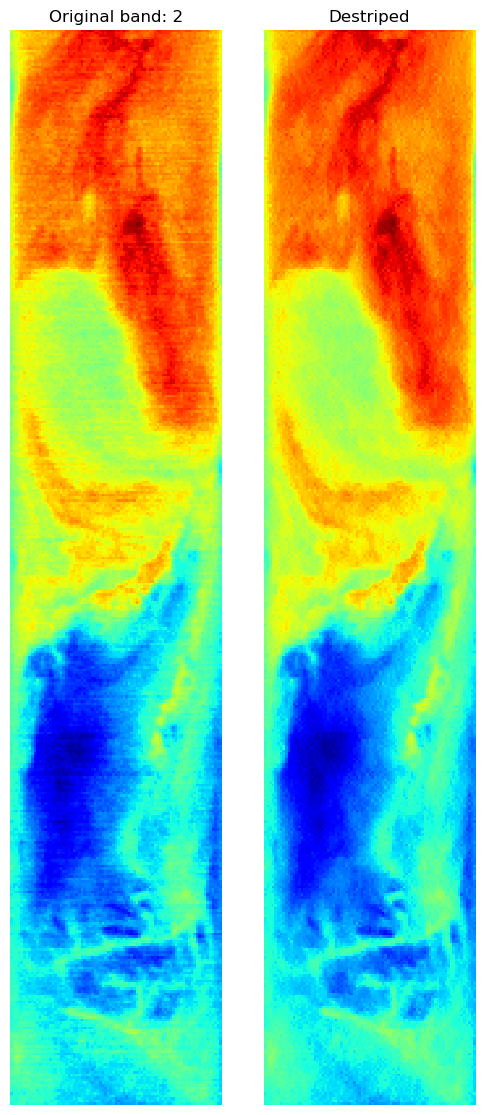

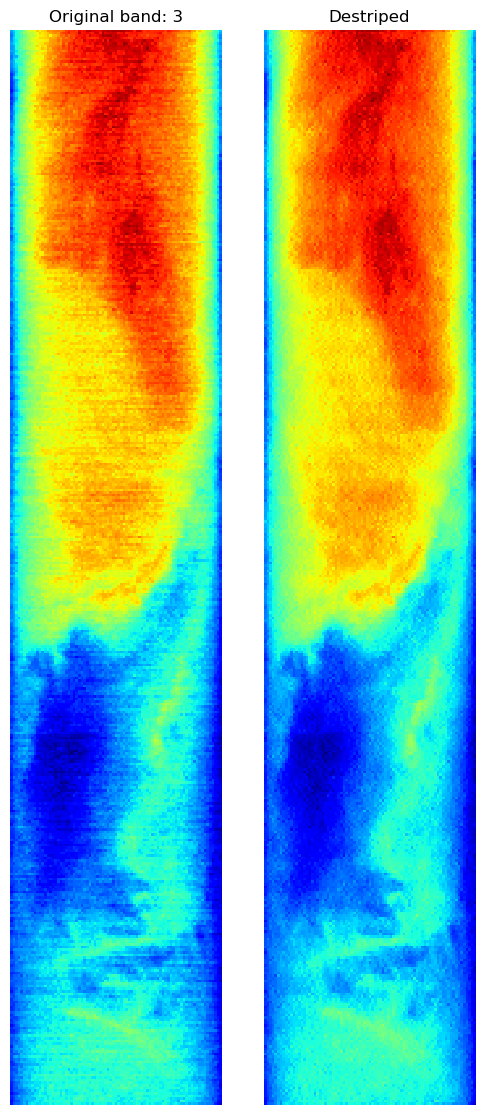

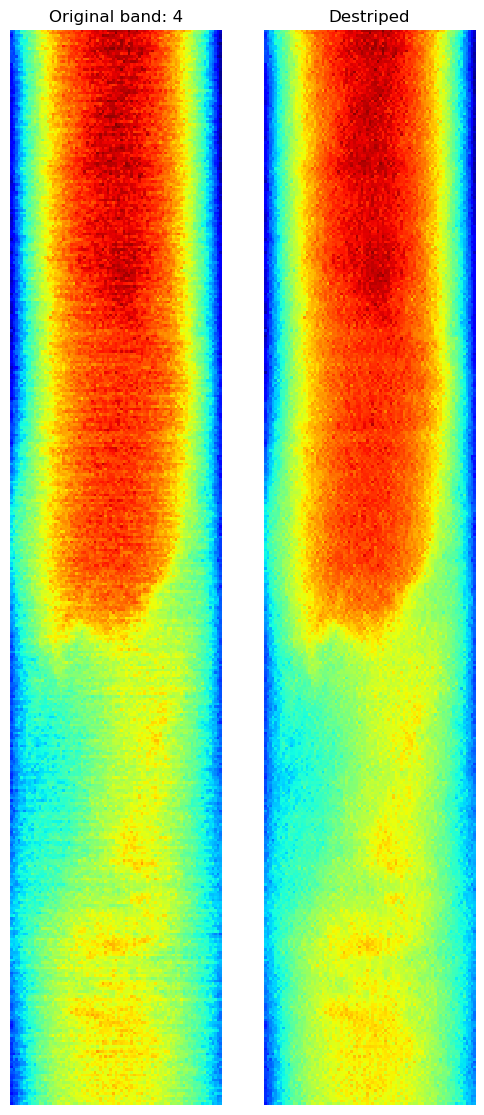

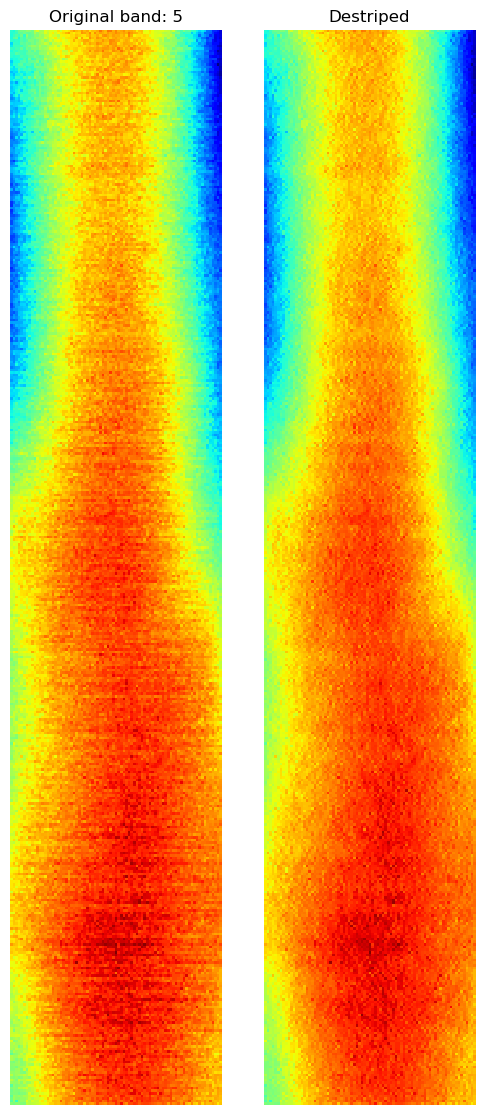

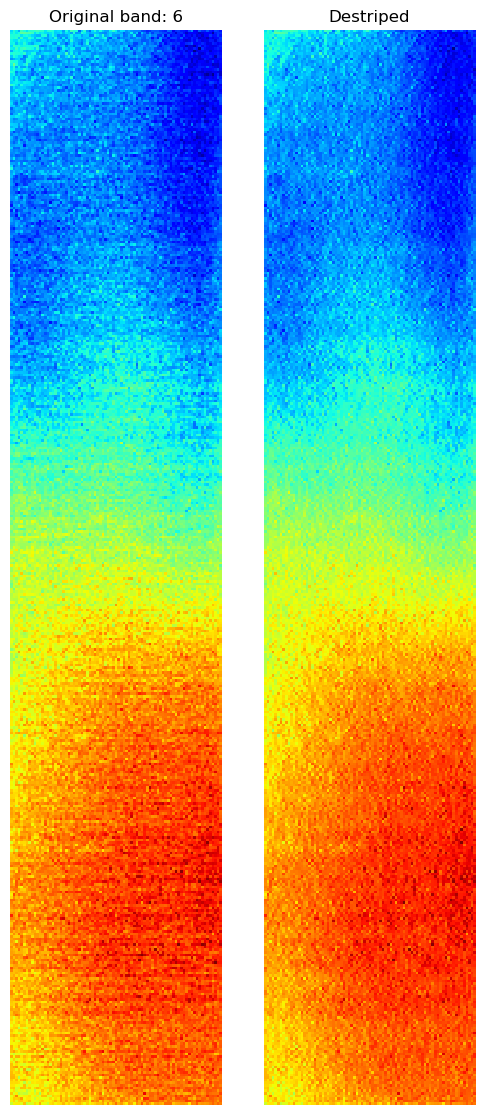

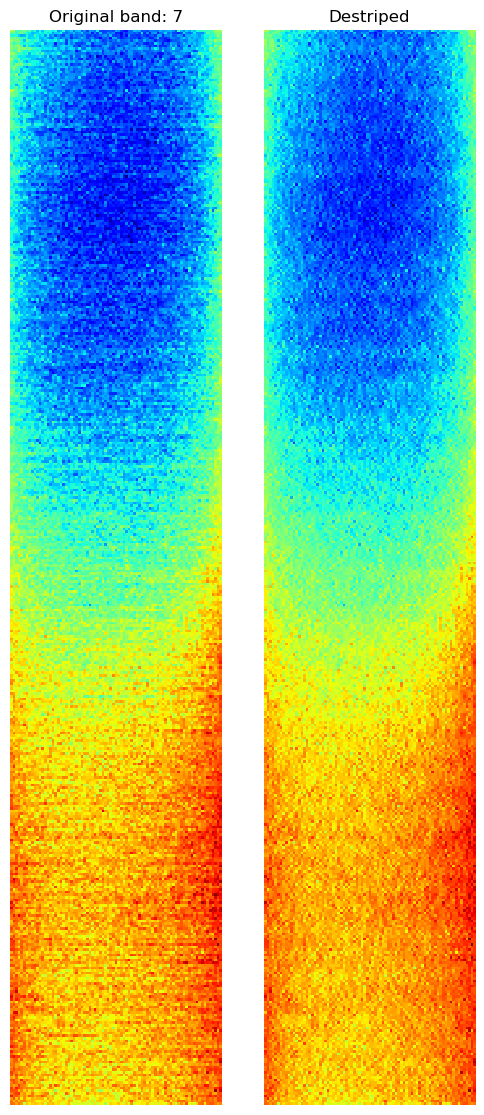

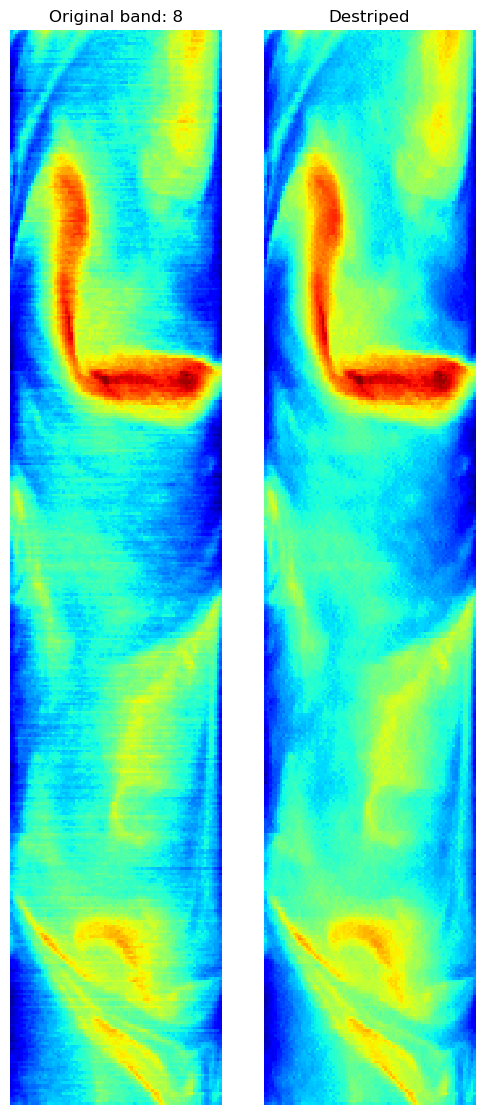

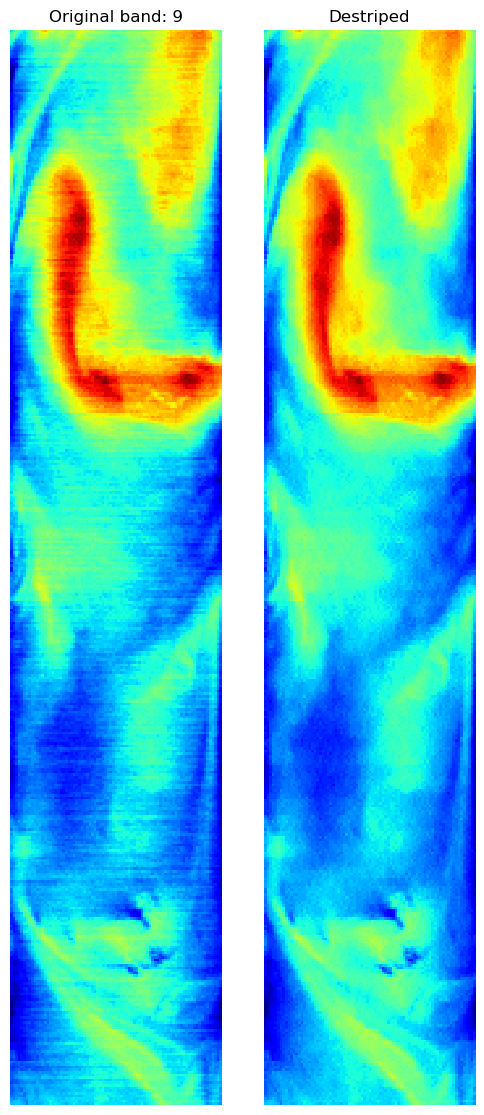

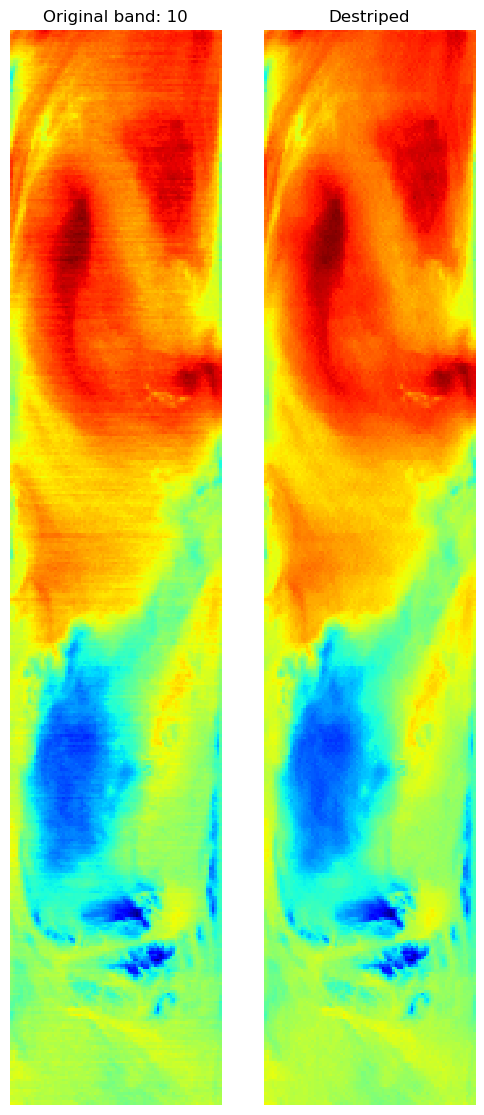

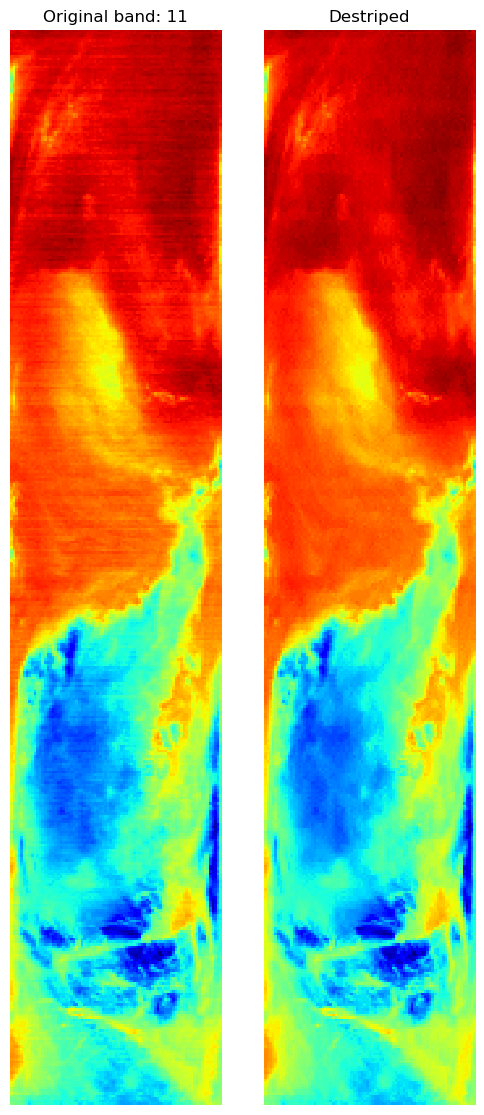

In [7]:
for band in range(Nbands):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 30))
    axes[0].imshow(bt_all[:, :, band], interpolation='nearest',cmap='jet')
    axes[0].set_title(f'Original band: {band}')
    axes[0].axis('off') 

    axes[1].imshow(bt_destriped[:, :, band], interpolation='nearest',cmap='jet') 
    axes[1].set_title('Destriped')
    axes[1].axis('off') 

    plt.show()